# **KMM**

In [ ]:
import numpy as np
from PIL import Image
import cv2

In [28]:
def KMM(farray:np.ndarray, show:bool = True) -> np.ndarray:
    uno = mark_black_pixels(farray)
    k = 1
    while not one_pixel_width_skeleton(uno):
        print(f"Iteration {k}")
        dos = change_ones_to_twos(uno)
        tres = change_twos_to_threes(dos)
        cuatro = change_to_fours(tres)
        no_fours = remove_fours(cuatro)
        i_max = farray.shape[0] * farray.shape[1]
        tmp = no_fours.copy()
        for N in [2, 3]:
            for i in range(i_max):
                i_row = i // no_fours.shape[1]
                i_col = i % no_fours.shape[1]
                if no_fours[i_row][i_col] == N:
                    pixel_weight = calculate_pixel_weight(no_fours, i)
                    if should_be_deleted(pixel_weight):
                        tmp[i_row][i_col] = 0
                    else:
                        tmp[i_row][i_col] = 1
               
        uno = tmp.copy()
        uno = map_to_ones(uno)
        if show:
            print_from_arr(uno)
        k += 1
    return uno 

def should_be_deleted(pixel_weight:int) -> bool:
    assert (pixel_weight >= 0 and pixel_weight <= 255), f"Pixel weight should be between 0 and 255, not {pixel_weight}"
    weights_to_delete = np.array([
        3, 5, 7, 12, 13, 14, 15, 20,
        21, 22, 23, 28, 29, 30, 31, 48,
        52, 53, 54, 55, 56, 60, 61, 62,
        63, 65, 67, 69, 71, 77, 79, 80,
        81, 83, 84, 85, 86, 87, 88, 89,
        91, 92, 93, 94, 95, 97, 99, 101,
        103, 109, 111, 112, 113, 115, 116, 117,
        118, 119, 120, 121, 123, 124, 125, 126,
        127, 131, 133, 135, 141, 143, 149, 151,
        157, 159, 181, 183, 189, 191, 192, 193,
        195, 197, 199, 205, 207, 208, 209, 211,
        212, 213, 214, 215, 216, 217, 219, 220,
        221, 222, 223, 224, 225, 227, 229, 231,
        237, 239, 240, 241, 243, 244, 245, 246,
        247, 248, 249, 251, 252, 253, 254, 255
    ])
    
    return pixel_weight in weights_to_delete
    
def calculate_pixel_weight(array:np.ndarray, index:int) -> int:    
    assert (index >= 0 and index < array.shape[0] * array.shape[1]), "Index should be between 0 and the size of the array"
    
    mask = np.array([
        [128, 1, 2],
        [64, 0, 4],
        [32, 16, 8]
    ])
    
    rows, cols = array.shape
    row = index // cols
    col = index % cols
    
    total = 0

    for i in range(-1, 2):        
        for j in range(-1, 2):    
            r = row + i
            c = col + j

            if (r >= 0 and r < rows) and (c >= 0 and c < cols):
                pixel_value = array[r, c]
            else:
                pixel_value = 0  
            
            total += mask[i+1, j+1] * pixel_value if pixel_value == 0 else 1

    return total

def remove_fours(array:np.ndarray) -> np.ndarray:
    t = array.copy()
    t[t == 4] = 0
    return t

def mark_black_pixels(array:np.ndarray) -> np.ndarray:
    assert np.all(np.isin(array, [0, 255])), "Array should be with 0 (black), and 255 (white) values only"
    t = array.copy()
    t[t == 0] = 1
    t[t == 255] = 0
    return t

def change_ones_to_twos(array:np.ndarray) -> np.ndarray:
    assert np.all(np.isin(array, [0, 1])), "Array should be with 0 and 1 values only"
    
    t = array.copy()
    padded = np.pad(t, pad_width=1, mode='constant', constant_values=10)
    rows, cols = padded.shape
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if padded[i, j] == 1:
                neighbors = padded[i-1:i+2, j-1:j+2].flatten()
                if 0 in neighbors:
                    t[i-1, j-1] = 2
    return t

def change_twos_to_threes(array:np.ndarray) -> np.ndarray:
    assert np.all(np.isin(array, [0, 1, 2])), "Array should be with 0, 1 and 2 values only"
    
    t = array.copy()
    padded = np.pad(t, pad_width=1, mode='constant', constant_values=10)
    rows, cols = padded.shape
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if padded[i, j] == 2:
                neighbors = padded[i-1:i+2, j-1:j+2]
                if neighbors[0, 1] != 0 and neighbors[1, 0] != 0 and neighbors[1, 2] != 0 and neighbors[2, 1] != 0:
                    t[i-1, j-1] = 3
    return t

def change_to_fours(array: np.ndarray) -> np.ndarray:
    assert np.all(np.isin(array, [0, 1, 2, 3])), "Array should be with 0, 1, 2 and 3 values only"
    
    rows, cols = array.shape
    t = array.copy()

    def get_neighbors(x, y):
        neighbors = []
        for (i, j) in [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]:
            if i == 0 and j == 0:
                continue  
            xi, yj = x + i, y + j
            if 0 <= xi < rows and 0 <= yj < cols:
                neighbors.append(array[xi, yj])
            else:
                neighbors.append(0)  
        return neighbors

    def are_neighbors_connected(neighbors):
        binary = np.array([1 if n != 0 else 0 for n in neighbors])
        
        ones_count = np.sum(binary)
        if ones_count not in [2, 3, 4]:
            return False
        
        binary = np.concatenate([binary, binary])

        max_consecutive = 0
        current = 0
        for val in binary:
            if val == 1:
                current += 1
                max_consecutive = max(max_consecutive, current)
            else:
                current = 0

        return max_consecutive == ones_count

    for x in range(rows):
        for y in range(cols):
            if t[x, y] == 0:
                continue
            neighbors = get_neighbors(x, y)
            if are_neighbors_connected(neighbors):
                t[x, y] = 4

    return t

def one_pixel_width_skeleton(array: np.ndarray) -> bool:
    assert np.all(np.isin(array, [0, 1, 2, 3, 4])), "Array should be with 0, 1, 2, 3 and 4 values only"
    rows, cols = array.shape
    
    for i in range(rows - 1):
        for j in range(cols - 1):
            window = array[i:i+2, j:j+2]
            if np.all(window != 0):
                return False
    return True    

def print_from_arr(array:np.ndarray) -> None:
    assert np.all(np.isin(array, [0, 1])), "Array should be with 0 and 1 values only"
    
    t = array.copy()
    t[array == 1] = 0
    t[array == 0] = 255
    t = t.astype(np.uint8)
    img = Image.fromarray(t)
    img.show()  
    
def map_to_ones(array:np.ndarray) -> np.ndarray:
    assert np.all(np.isin(array, [0, 1, 2, 3, 4])), "Array should be with 0, 1, 2, 3 and 4 values only"
    
    t = array.copy()
    t[array == 1] = 1
    t[array == 0] = 0
    t[array == 2] = 1
    t[array == 3] = 1
    t[array == 4] = 1
    return t

# **Original fingerprint**

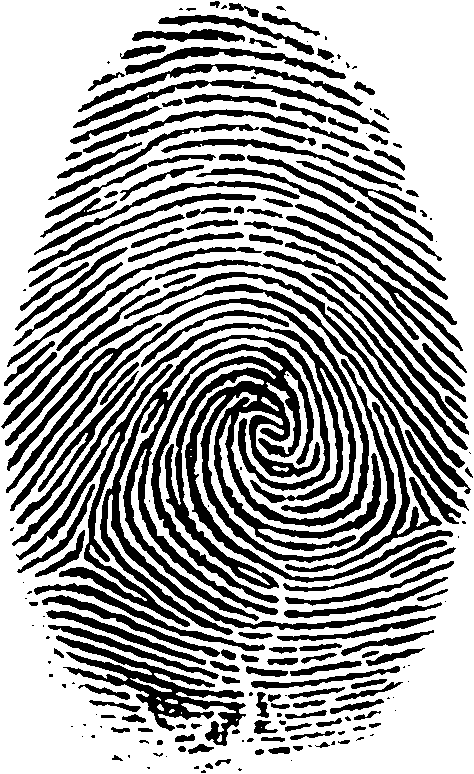

In [27]:
image = Image.open(f'test_data/tester.bmp')
image_np = np.array(image)
_, farray = cv2.threshold(image_np, 127, 255, cv2.THRESH_BINARY)
img = Image.fromarray(farray)
if farray.ndim == 3:
    farray = farray[:, :, 0]
img = Image.fromarray(farray)
img

# **Skeleton**

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8


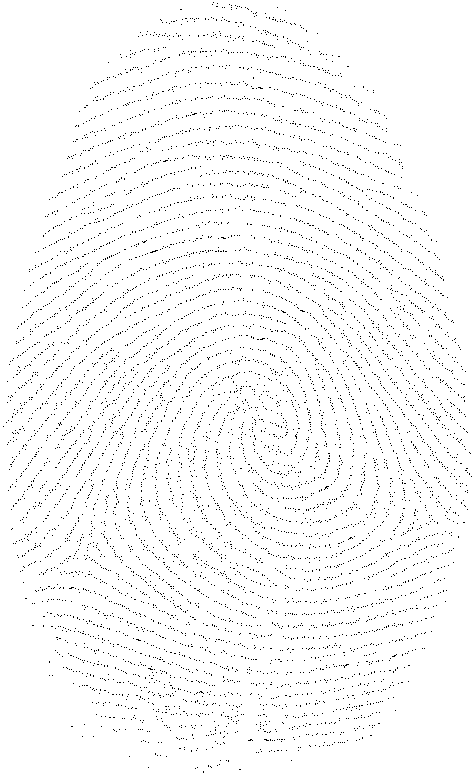

In [30]:
skeleton = KMM(farray, show = True)
skeleton[skeleton == 0] = 255
skeleton[skeleton == 1] = 0


skeleton = skeleton.astype(np.uint8)
img = Image.fromarray(skeleton)
img